# Import Library, Define Function, Load Data
* import necssary library
* a function for model and cross-validation

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib

# library for ML
import sklearn
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


# library for plot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/xbj/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


###  Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training mean square error
3. perform CV is performCV is True
4. plot Feature Importance if printFeatureImportance is True

In [2]:
def modelfit(model, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    columns = X.columns.values
    model.fit(X, y)
        
    #Predict training set:
    y_predictions = model.predict(X)
        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print "\nModel Report"
    print "Mean Square Error: %.4g" % metrics.mean_squared_error(y, y_predictions)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
def xgb_modelfit(alg, X, y, useTrainCV=True, cv_folds=4, early_stopping_rounds=50):
    feature_names = X.columns.values
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label = y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
        
    #Print model report:
    print "\nModel Report"
    print "Mean Square Error : %.4g" % metrics.mean_squared_error(y, dtrain_predictions)
    
    #print feature importance            
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [4]:
# # learning curver
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring="neg_mean_squared_error",cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
# load data
train_csv = pd.read_csv(filepath_or_buffer="../data/data_train.csv",sep=";")
test_csv = pd.read_csv(filepath_or_buffer="../data/data_test.csv",sep=";")

In [6]:
# concat train and test for feature engineering
# deal na and TimeStamp data
all_data = pd.concat((train_csv, test_csv))
all_data.Speed = all_data.Speed.fillna(all_data.Distance/all_data.Measured_time)
all_data.Date = pd.to_datetime(all_data.Date)
all_data.Time = pd.to_datetime(all_data.Time)
all_data['Year'] = all_data.Date.apply(lambda date:date.year)
all_data['Month'] = all_data.Date.apply(lambda date:date.month)
all_data['Day'] = all_data.Date.apply(lambda date:date.day)
all_data['Hour'] = all_data.Time.apply(lambda time:time.hour)
all_data['Average_point'] = (all_data.Highest_point + all_data.Lowest_point) / 2.0

In [7]:
all_data.head()

,Average_Gradient,Average_heart_rate,Cadence,Date,Distance,Highest_point,Id,Index,Lowest_point,Max_Gradient,...,Moving_time,Power,RiderID,Speed,Time,Year,Month,Day,Hour,Average_point
0,0.0,105.8,85.3,2015-02-09,9980.400,128.4,NaN,78294,124.6,5.0,...,1375,92.4,1,7.258473,2017-01-04 05:50:12,2015,2,9,5,126.50
1,3.3,157.5,88.3,2014-08-23,1666.010,204.6,NaN,62861,147.9,16.0,...,252,271.9,1,6.611151,2017-01-04 12:52:26,2014,8,23,12,176.25
2,0.0,158.9,103.4,2014-09-30,345.600,59.0,NaN,88658,59.0,0.0,...,36,274.4,1,9.600000,2017-01-04 06:19:38,2014,9,30,6,59.00
3,-8.3,99.1,66.4,2015-02-21,1572.900,617.8,NaN,77748,487.2,-0.5,...,123,72.8,1,12.787805,2017-01-04 14:25:18,2015,2,21,14,552.50
4,-7.6,100.3,60.3,2012-08-24,435.352,54.4,NaN,64485,21.4,-4.8,...,59,4.9,1,7.378847,2017-01-04 06:34:28,2012,8,24,6,37.90


# regression for speed
Author: Bujie Xu

speed = Distance/measured time

### Speed: predict result

In [9]:
speed_test = test_csv.loc[test_csv.Speed.isnull(),:]
speed_test.loc[:,'Speed'] = speed_test.Distance/speed_test.Measured_time
speed_result = speed_test.loc[:,['Id','Speed']]
speed_result.head()

,Id,Speed
0,1,10.134000
1,2,6.063448
2,3,12.037037
3,4,5.485714
4,5,6.646154


In [10]:
all_data.columns

Index([u'Average_Gradient', u'Average_heart_rate', u'Cadence', u'Date',
       u'Distance', u'Highest_point', u'Id', u'Index', u'Lowest_point',
       u'Max_Gradient', u'Max_heart_rate', u'Measured_time', u'Moving_time',
       u'Power', u'RiderID', u'Speed', u'Time', u'Year', u'Month', u'Day',
       u'Hour', u'Average_point'],
      dtype='object')

## Part2 :Regression for Candence

## Data Preprocessing (Cadence)

In [55]:
# remove useless columns
cadence = all_data

In [56]:
# Add new feature Season
cadence.loc[lambda d:(d.Month >=3) & (d.Month <=5), 'Season'] = 'Spring'
cadence.loc[lambda d:(d.Month >=6) & (d.Month <=8), 'Season'] = 'Summer'
cadence.loc[lambda d:(d.Month >=9) & (d.Month <=11), 'Season'] = 'Autumn'
cadence.loc[lambda d:(d.Month == 12) | (d.Month <=2), 'Season'] = 'Winter'

# Add new feature, day,night
cadence['Day_Time'] = 0
cadence.loc[lambda d:(d.Hour >=6) &(d.Hour <=18), 'Day_Time'] = 1

In [57]:
# feature engineering
dropColumns = ['Index','Date','Time','Moving_time','Month','Day','Hour']
cadence = cadence.drop(dropColumns, axis = 1)
cadence.RiderID = cadence.RiderID.astype('category')
cadence.Year = cadence.Year.astype('category')
cadence.Season = cadence.Season.astype('category')
cadence['Speed^2'] = cadence.Speed**2
cadence['Speed^3'] = cadence.Speed**3
cadence['New_Distance'] = cadence.Distance * np.cos(abs(cadence.Average_Gradient))
cadence['Average_point'] = (cadence.Highest_point + cadence.Lowest_point)/2
cadence['Max_Avg_Gradient'] = cadence.Max_Gradient - cadence.Average_Gradient
cadence['Max_Avg_heart_rage'] = cadence.Max_heart_rate - cadence.Average_heart_rate
cadence['1/Measured_Time'] = 1/cadence.Measured_time
cadence = pd.get_dummies(cadence)

In [58]:
cadence.columns

Index([u'Average_Gradient', u'Average_heart_rate', u'Cadence', u'Distance',
       u'Highest_point', u'Id', u'Lowest_point', u'Max_Gradient',
       u'Max_heart_rate', u'Measured_time', u'Power', u'Speed',
       u'Average_point', u'Day_Time', u'Max_GradientVs0', u'Speed^2',
       u'Speed^3', u'New_Distance', u'Max_Avg_Gradient', u'Max_Avg_heart_rage',
       u'1/Measured_Time', u'RiderID_1', u'RiderID_2', u'RiderID_3',
       u'RiderID_4', u'RiderID_5', u'RiderID_6', u'RiderID_7', u'RiderID_8',
       u'RiderID_9', u'RiderID_10', u'RiderID_11', u'RiderID_12',
       u'RiderID_13', u'RiderID_14', u'RiderID_15', u'Year_2008', u'Year_2009',
       u'Year_2010', u'Year_2011', u'Year_2012', u'Year_2013', u'Year_2014',
       u'Year_2015', u'Year_2016', u'Season_Autumn', u'Season_Spring',
       u'Season_Summer', u'Season_Winter'],
      dtype='object')

In [59]:
cadence_train = cadence.dropna(subset=['Cadence','Power'],how = 'any')
cadence_test = cadence.loc[cadence['Cadence'].isnull()]
dropList = ['Cadence','Id']
cadence_X_train, cadence_y = cadence_train.drop(dropList, axis=1), cadence_train['Cadence']
cadence_columns = cadence_X_train.columns
cadence_X_test = cadence_test.drop(dropList, axis=1)
cadence_X_train.shape

(120000, 47)

## Cadence: Models 

### 1. RandomForestRegressor

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor()
param_grid = {'n_estimators': [500], 'max_features': ['sqrt']}
cadence_randomForest = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=4, cv=5, verbose=20, scoring="neg_mean_squared_error")
cadence_randomForest.fit(cadence_X_train,cadence_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_features=sqrt, n_estimators=500 .............................
[CV] max_features=sqrt, n_estimators=500 .............................
[CV] max_features=sqrt, n_estimators=500 .............................
[CV] max_features=sqrt, n_estimators=500 .............................
[CV]  max_features=sqrt, n_estimators=500, score=-97.051391, total= 7.5min
[CV]  max_features=sqrt, n_estimators=500, score=-180.507966, total= 7.5min
[CV]  max_features=sqrt, n_estimators=500, score=-111.638711, total= 7.5min
[CV]  max_features=sqrt, n_estimators=500, score=-80.277630, total= 7.5min


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  9.2min remaining: 13.8min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:  9.2min remaining:  6.1min


[CV] max_features=sqrt, n_estimators=500 .............................
[CV]  max_features=sqrt, n_estimators=500, score=-118.948789, total= 3.3min


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 12.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [500], 'max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=20)

In [18]:
cadence_randomForest.best_score_

-117.68489740553301

### 2. Cadence: xgboost model:

[0]	train-rmse:11.9376+0.0121815	test-rmse:12.1083+0.062059
[1]	train-rmse:11.3653+0.110389	test-rmse:11.6261+0.13523
[2]	train-rmse:10.9897+0.125175	test-rmse:11.3161+0.136134
[3]	train-rmse:10.7842+0.132619	test-rmse:11.1636+0.126701
[4]	train-rmse:10.6355+0.154602	test-rmse:11.1031+0.127696
[5]	train-rmse:10.5238+0.13925	test-rmse:11.0443+0.104731
[6]	train-rmse:10.4284+0.118743	test-rmse:11.0229+0.0913231
[7]	train-rmse:10.3392+0.118659	test-rmse:10.9782+0.105331
[8]	train-rmse:10.2544+0.110475	test-rmse:10.9431+0.114509
[9]	train-rmse:10.1753+0.126245	test-rmse:10.9342+0.11469
[10]	train-rmse:10.1191+0.111285	test-rmse:10.9391+0.100849
[11]	train-rmse:9.99513+0.102564	test-rmse:10.8838+0.0956608
[12]	train-rmse:9.92718+0.0750714	test-rmse:10.8814+0.0850451
[13]	train-rmse:9.87413+0.0779998	test-rmse:10.8554+0.0856708
[14]	train-rmse:9.80504+0.0779263	test-rmse:10.8633+0.093803
[15]	train-rmse:9.75056+0.0713457	test-rmse:10.8577+0.088326
[16]	train-rmse:9.7029+0.0756368	test-rmse:1

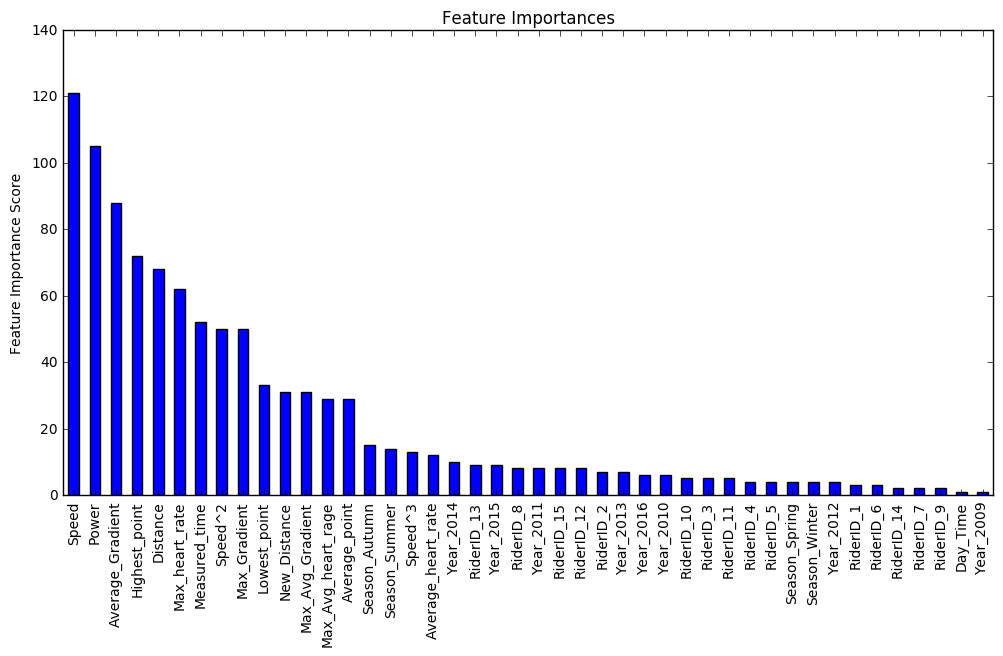

In [102]:
xgb1 = XGBRegressor(
        learning_rate =1,
        n_estimators= 200,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=1,
        colsample_bytree=0.4,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        seed=2017)
xgb_modelfit(xgb1, cadence_X_train, cadence_y)

use learning_rate = 1, n_estimators = 100 to tune parameters

In [103]:
c_param_test1 = {
    'max_depth':[4,5,6],
    'min_child_weight':[3,4,5]
}
c_gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate = 1, n_estimators= 100, 
                                        min_child_weight=1, gamma=0, subsample=1, colsample_bytree=0.4,
                                        objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = c_param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
c_gsearch1.fit(cadence_X_train, cadence_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [104]:
c_gsearch1.grid_scores_, c_gsearch1.best_score_, c_gsearch1.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -132.97160, std: 29.37225, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -135.63316, std: 33.46226, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -133.05091, std: 30.88534, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -140.80962, std: 29.96827, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -138.62335, std: 28.13034, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -140.25675, std: 32.20013, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -150.13759, std: 30.31264, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -146.50041, std: 36.11299, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -146.57711, std: 32.92418, params: {'max_depth': 6, 'min_child_weight': 5}],
 -132.971596469628,
 {'max_depth': 4, 'min_child_weight': 3})

In [106]:
c_param_test1b = {
    'max_depth':[2,3,4],
    'min_child_weight':[1,2,3]
}
c_gsearch1b = GridSearchCV(estimator = XGBRegressor( learning_rate = 1, n_estimators= 100, 
                                         gamma=0, subsample=1, colsample_bytree=0.4,
                                        objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = c_param_test1b, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
c_gsearch1b.fit(cadence_X_train, cadence_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [107]:
c_gsearch1b.grid_scores_, c_gsearch1b.best_score_, c_gsearch1b.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -130.10253, std: 34.48733, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -133.23662, std: 38.31277, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: -131.13276, std: 35.92480, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -127.27722, std: 26.40977, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -126.87337, std: 27.12933, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -129.44542, std: 29.13559, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -131.52442, std: 31.72120, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -134.85211, std: 31.43745, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -132.97160, std: 29.37225, params: {'max_depth': 4, 'min_child_weight': 3}],
 -126.87336661984628,
 {'max_depth': 3, 'min_child_weight': 2})

In [110]:
c_param_test2 = {
    'colsample_bytree':[0.2, 0.3, 0.4, 0.5]
}
c_gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate = 1, n_estimators= 100, max_depth= 3,
                                         gamma=0, subsample=1, min_child_weight = 2,
                                        objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = c_param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
c_gsearch2.fit(cadence_X_train, cadence_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=1, max_delta_step=0, max_depth=3, min_child_weight=2,
       missing=None, n_estimators=100, nthread=4, objective='reg:linear',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2017,
       silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.2, 0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [111]:
c_gsearch2.grid_scores_, c_gsearch2.best_score_, c_gsearch2.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -128.17183, std: 29.59397, params: {'colsample_bytree': 0.2},
  mean: -128.72772, std: 32.00406, params: {'colsample_bytree': 0.3},
  mean: -126.87337, std: 27.12933, params: {'colsample_bytree': 0.4},
  mean: -129.29859, std: 27.69490, params: {'colsample_bytree': 0.5}],
 -126.87336661984628,
 {'colsample_bytree': 0.4})

In [60]:
c_param_test3 = {
    'learning_rate':[0.1],
    'n_estimators':[1000]
}
c_gsearch3 = GridSearchCV(estimator = XGBRegressor(gamma=0, subsample=1, colsample_bytree=0.4,max_depth=3,
                                                   min_child_weight=2, objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = c_param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
c_gsearch3.fit(cadence_X_train, cadence_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [1000], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [114]:
c_gsearch3.grid_scores_, c_gsearch3.best_score_, c_gsearch3.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -118.94572, std: 27.65405, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: -115.34686, std: 26.45173, params: {'n_estimators': 1000, 'learning_rate': 0.05},
  mean: -116.05697, std: 27.05830, params: {'n_estimators': 500, 'learning_rate': 0.1},
  mean: -113.80983, std: 26.54353, params: {'n_estimators': 1000, 'learning_rate': 0.1},
  mean: -117.45024, std: 26.74864, params: {'n_estimators': 500, 'learning_rate': 0.5},
  mean: -120.02267, std: 27.66735, params: {'n_estimators': 1000, 'learning_rate': 0.5}],
 -113.80983023350461,
 {'learning_rate': 0.1, 'n_estimators': 1000})

### 3. Cadence: AdaBoost

In [21]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
rd = DecisionTreeRegressor(max_depth=7)
clf = AdaBoostRegressor(n_estimators=500,base_estimator=rd, learning_rate = 0.5, random_state= 2017)
scores = cross_val_score(clf, cadence_X_train, cadence_y, scoring = "neg_mean_squared_error", n_jobs=2)
# param_grid = {'n_estimators': [1000], 'max_features': [0.2]}
# cadence_model_randomForestRegressor = GridSearchCV(estimator=rfr, param_grid=param_grid, 
#                                                    n_jobs=-1, cv=5, verbose=20, scoring="neg_mean_squared_error")
# cadence_model_AdaBoost.fit(cadence_X_train,cadence_y)

In [22]:
scores

array([-653.71006308, -785.60322364, -513.625924  ])

### 4. XGM model (Cadence)
There 2 types of parameters here:
1. Tree-specific parameters
  * min_samples_split
  * min_samples_leaf
  * max_depth
  * min_leaf_nodes
  * max_features
  * loss function
2. Boosting specific paramters
  * n_estimators
  * learning_rate
  * subsample


**Step1. 首先确定一个暂定的learning_rate和n_estimators**

**Step2. 然后用1中的learning_rate和n_estimators来调整tree-specific paramters**

**Step3. 然后用tree-specific paramters来调整Boosting specific paramters**

##### Step 1- Find the number of estimators for a high learning rate

We will use the following benchmarks for parameters:
1. min_samples_split = 500 : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value
2. min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.
3. max_depth = 8 : since high number of observations and predictors, choose relatively high value
4. max_features = 'sqrt' : general thumbrule to start with
5. subsample = 0.8 : typically used value (will be tuned later)


In [73]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators':range(100,2000,500)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate= 0.1 , min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=3)
gsearch1.fit(cadence_X_train, cadence_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=500, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [100, 600, 1100, 1600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -127.34266, std: 30.70390, params: {'n_estimators': 100},
  mean: -121.04671, std: 26.27690, params: {'n_estimators': 600},
  mean: -120.55431, std: 25.27134, params: {'n_estimators': 1100},
  mean: -120.54131, std: 24.63748, params: {'n_estimators': 1600}],
 {'n_estimators': 1600},
 -120.54130533055474)

So we got 50 as the optimal estimators for the 1 learning rate. 

## Step 2- Tune tree-specific parameters
Now, lets move onto tuning the tree parameters. We will do this in 2 stages:
1. Tune max_depth and num_samples_split
2. Tune min_samples_leaf
3. Tune max_features

In [43]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,100)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=1, n_estimators= 50,
                                  min_samples_leaf=50,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(cadence_X_train, cadence_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=3, max_features='sqrt',
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=50, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=10, subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

we get the follow as optimal parameter
1. max_depth: 5
2. min_samples_split :400

#### Now let's tune max_features
we test sqrt to 30%

In [ ]:
gsearch3.best_estimator_, gsearch3.best_params_,gsearch3.best_score_

### Predict (Cadence)

In [63]:
# define a function for predict result
def cadenec_predict(model):
    cadence_test.loc[:,'Cadence'] = model.predict(cadence_X_test)
    result = cadence_test.loc[:,['Id','Cadence']]
    return result

In [64]:
cadence_result = cadenec_predict(c_gsearch3.best_estimator_)

# Part3: Power: Data Preprocessing

In [44]:
power = all_data

In [45]:
# Add new feature Season
power.loc[lambda d:(d.Month >=3) & (d.Month <=5), 'Season'] = 'Spring'
power.loc[lambda d:(d.Month >=6) & (d.Month <=8), 'Season'] = 'Summer'
power.loc[lambda d:(d.Month >=9) & (d.Month <=11), 'Season'] = 'Autumn'
power.loc[lambda d:(d.Month == 12) | (d.Month <=2), 'Season'] = 'Winter'

# Add new feature, day,night
power['Day_Time'] = 0
power.loc[lambda d:(d.Hour >=6) &(d.Hour <=18), 'Day_Time'] = 1

# Add New feature, Max_
power['Max_GradientVs0'] = 1
power.loc[lambda d:d.Max_Gradient < 0, 'Max_GradientVs0'] = -1

In [46]:
# feature engineering
dropColumns = ['Index','Date','Time','Moving_time','Month','Day','Hour']
power = power.drop(dropColumns, axis = 1)
power.RiderID = power.RiderID.astype('category')
power.Year = power.Year.astype('category')
power.Season = power.Season.astype('category')
power['Speed^2'] = power.Speed**2
power['Speed^3'] = power.Speed**3
power['Average_point'] = (power.Highest_point + power.Lowest_point)/2
power['Max_Avg_Gradient'] = power.Max_Gradient - power.Average_Gradient
power['Max_Avg_heart_rage'] = power.Max_heart_rate - power.Average_heart_rate
power['Energy'] = power.Power * power.Measured_time
power = pd.get_dummies(power)

In [47]:
power_train = power.dropna(subset=['Cadence','Power'],how = 'any')
power_test = power.loc[power['Power'].isnull()]
dropList = ['Power','Id','Energy']
power_X_train, power_y = power_train.drop(dropList, axis=1), power_train['Energy']
columns = power_X_train.columns
power_X_test = power_test.drop(dropList, axis=1)

In [48]:
power_X_train.columns

Index([u'Average_Gradient', u'Average_heart_rate', u'Cadence', u'Distance',
       u'Highest_point', u'Lowest_point', u'Max_Gradient', u'Max_heart_rate',
       u'Measured_time', u'Speed', u'Average_point', u'Day_Time',
       u'Max_GradientVs0', u'Speed^2', u'Speed^3', u'Max_Avg_Gradient',
       u'Max_Avg_heart_rage', u'RiderID_1', u'RiderID_2', u'RiderID_3',
       u'RiderID_4', u'RiderID_5', u'RiderID_6', u'RiderID_7', u'RiderID_8',
       u'RiderID_9', u'RiderID_10', u'RiderID_11', u'RiderID_12',
       u'RiderID_13', u'RiderID_14', u'RiderID_15', u'Year_2008', u'Year_2009',
       u'Year_2010', u'Year_2011', u'Year_2012', u'Year_2013', u'Year_2014',
       u'Year_2015', u'Year_2016', u'Season_Autumn', u'Season_Spring',
       u'Season_Summer', u'Season_Winter'],
      dtype='object')

In [65]:
power_test.columns

Index([u'Average_Gradient', u'Average_heart_rate', u'Cadence', u'Distance',
       u'Highest_point', u'Id', u'Lowest_point', u'Max_Gradient',
       u'Max_heart_rate', u'Measured_time', u'Power', u'Speed',
       u'Average_point', u'Day_Time', u'Max_GradientVs0', u'Speed^2',
       u'Speed^3', u'Max_Avg_Gradient', u'Max_Avg_heart_rage', u'Energy',
       u'RiderID_1', u'RiderID_2', u'RiderID_3', u'RiderID_4', u'RiderID_5',
       u'RiderID_6', u'RiderID_7', u'RiderID_8', u'RiderID_9', u'RiderID_10',
       u'RiderID_11', u'RiderID_12', u'RiderID_13', u'RiderID_14',
       u'RiderID_15', u'Year_2008', u'Year_2009', u'Year_2010', u'Year_2011',
       u'Year_2012', u'Year_2013', u'Year_2014', u'Year_2015', u'Year_2016',
       u'Season_Autumn', u'Season_Spring', u'Season_Summer', u'Season_Winter',
       u'Engery'],
      dtype='object')

## Power: Models

## Power: RandomForestRegressor

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor()
param_grid = {'n_estimators': [1000], 'max_features': [0.2, 'sqrt']}
power_randomForest = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=5, verbose=20, scoring="neg_mean_squared_error")
power_randomForest.fit(power_X_train, power_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] max_features=0.2, n_estimators=1000 .............................
[CV]  max_features=0.2, n_estimators=1000, score=-1954.285316, total= 9.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.1min remaining:    0.0s


[CV] max_features=0.2, n_estimators=1000 .............................
[CV]  max_features=0.2, n_estimators=1000, score=-3255.465330, total=10.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.7min remaining:    0.0s


[CV] max_features=0.2, n_estimators=1000 .............................
[CV]  max_features=0.2, n_estimators=1000, score=-2745.031442, total= 9.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 33.6min remaining:    0.0s


[CV] max_features=0.2, n_estimators=1000 .............................


KeyboardInterrupt: 

In [27]:
power_randomForest.grid_scores_,power_randomForest.best_score_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -2564.81425, std: 474.98426, params: {'max_features': 'sqrt', 'n_estimators': 1000}],
 -2564.814246608581)

[0, 1400, 0, 1400]

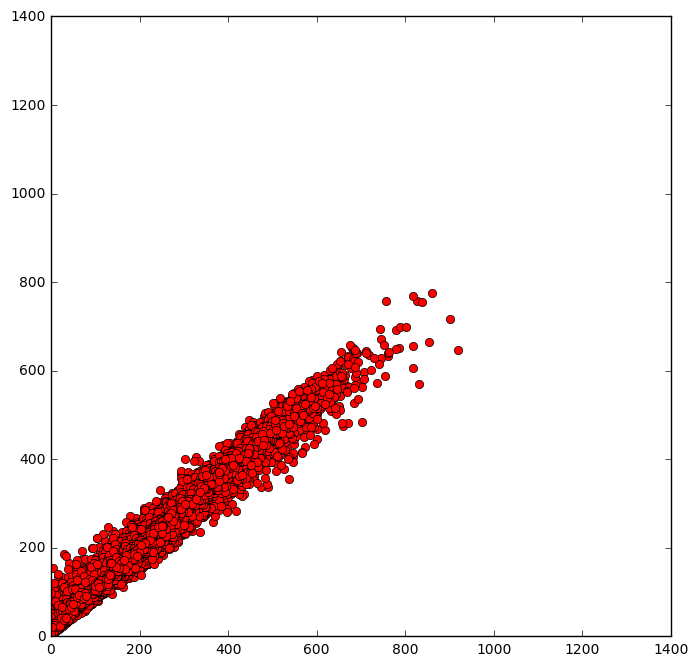

In [155]:
plt.figure(figsize=(8,8))
plt.plot(power_y, power_randomForest.predict(power_X_train), 'ro')
plt.axis([0,1400,0,1400])


Model Report
Mean Square Error: 267.9


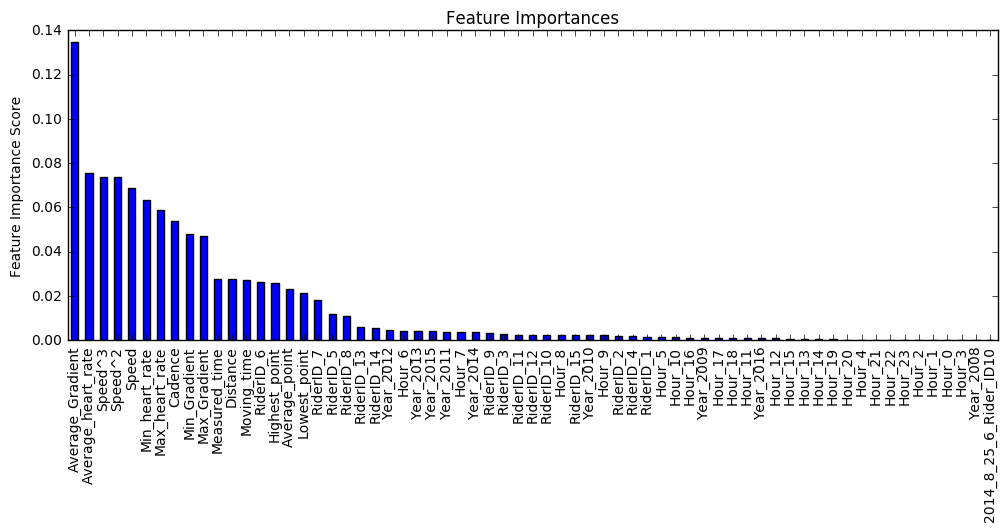

In [95]:
modelfit(model=power_randomForest.best_estimator_,X=power_X_train,y=power_y,performCV=False)

In [212]:
power_model_randomForest.best_estimator_,power_model_randomForest.best_score_,power_model_randomForest.best_params_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 -2439.3975099241266,
 {'max_features': 10, 'n_estimators': 500})

### Power: Xgboost

[0]	train-rmse:61.5117+0.124995	test-rmse:62.054+0.445907
[1]	train-rmse:58.1978+0.294927	test-rmse:59.1053+0.626385
[2]	train-rmse:55.8928+0.51176	test-rmse:57.1408+0.48944
[3]	train-rmse:54.4073+0.674682	test-rmse:56.0669+0.544218
[4]	train-rmse:53.2514+0.515613	test-rmse:55.139+0.713766
[5]	train-rmse:52.3638+0.413896	test-rmse:54.4349+0.737118
[6]	train-rmse:51.2883+0.295677	test-rmse:53.6366+0.49399
[7]	train-rmse:50.6833+0.344995	test-rmse:53.3145+0.507686
[8]	train-rmse:50.1099+0.292794	test-rmse:52.9129+0.610901
[9]	train-rmse:49.5253+0.217321	test-rmse:52.5146+0.724204
[10]	train-rmse:48.9034+0.411849	test-rmse:52.0553+0.697546
[11]	train-rmse:48.494+0.320975	test-rmse:51.7653+0.812201
[12]	train-rmse:48.1746+0.278516	test-rmse:51.6306+0.807815
[13]	train-rmse:47.6889+0.412915	test-rmse:51.3201+0.709113
[14]	train-rmse:47.3588+0.453555	test-rmse:51.2094+0.65159
[15]	train-rmse:47.0573+0.440606	test-rmse:51.0703+0.617461
[16]	train-rmse:46.7571+0.38634	test-rmse:50.9294+0.63894

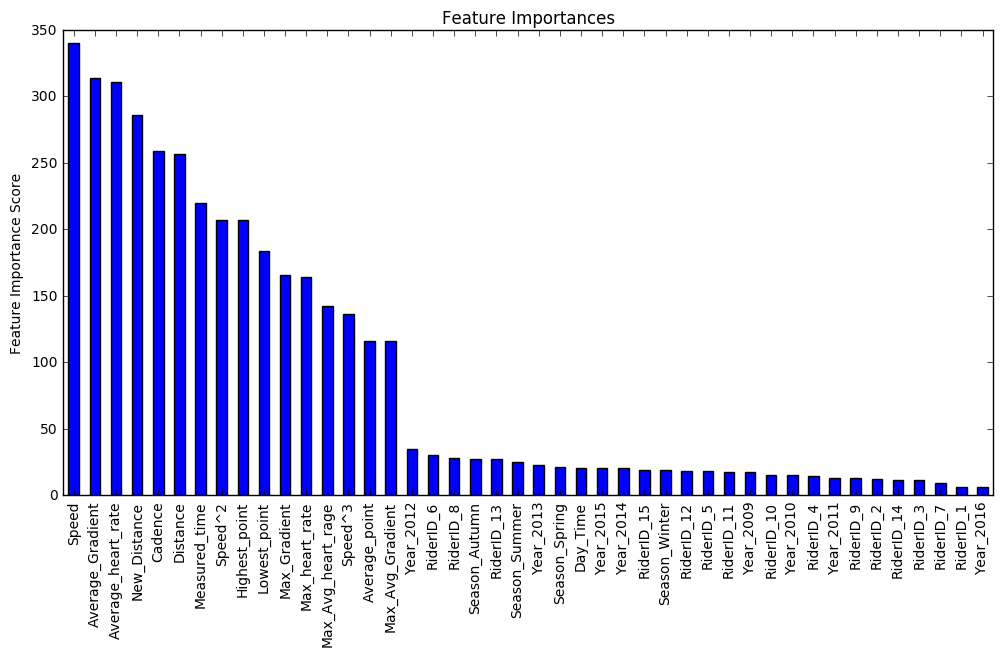

In [77]:
power_xgb = XGBRegressor(
        learning_rate = 1,
        n_estimators= 200,
        max_depth= 6,
        min_child_weight=1,
        gamma=0,
        subsample=1,
        colsample_bytree=0.4,
        objective= 'reg:linear',
        nthread=4,
        seed = 2017)
xgb_modelfit(alg=power_xgb,X=power_X_train,y=power_y,useTrainCV=True,cv_folds=5,early_stopping_rounds=10)

use learning rate = 1 and n_estimators = 78 to tune other parameter

In [111]:
power_xgb.fit(power_X_train, power_y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=1)

In [82]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':[4,5,6],
    'min_child_weight':[3,4,5]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate = 1, n_estimators= 78, 
                                        min_child_weight=1, gamma=0, subsample=1, colsample_bytree=0.4,
                                        objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
gsearch1.fit(power_X_train, power_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  8.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=78, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [83]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -2776.92912, std: 397.11067, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -2764.41713, std: 379.98224, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -2785.30040, std: 413.44172, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -2809.51866, std: 470.62747, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -2738.63782, std: 441.06689, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -2806.28506, std: 475.31115, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -2924.77489, std: 462.18964, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -2925.96746, std: 476.97400, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -2905.60636, std: 485.81999, params: {'max_depth': 6, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 4},
 -2738.6378197000281)

max_depth:5 , min_child_weight:4

In [84]:
param_test2 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch2 = GridSearchCV(estimator=XGBRegressor(n_estimators=78, max_depth=5, min_child_weight=4, learning_rate=1, 
                                               gamma=0,objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
gsearch2.fit(power_X_train, power_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 24.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=1, max_delta_step=0, max_depth=5, min_child_weight=4,
       missing=None, n_estimators=78, nthread=4, objective='reg:linear',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2017,
       silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [85]:
gsearch2.grid_scores_, gsearch2.best_score_, gsearch2.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -3243.00389, std: 581.40426, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -3201.74875, std: 629.96530, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -2982.72732, std: 577.59013, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -2888.09572, std: 506.71240, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -3267.78721, std: 636.10373, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -3074.74936, std: 557.92525, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -2870.38375, std: 534.36020, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -2842.23394, std: 504.07109, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -3148.94636, std: 579.63934, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -2984.33001, std: 451.25775, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -2910.92791, std: 499.99158, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -2

colsample_bytree:0.8, subsample:1

In [88]:
param_test2b = {
    'colsample_bytree':[0.3,0.4,0.8]
}
gsearch2b = GridSearchCV(estimator=XGBRegressor(n_estimators=78, max_depth=5, min_child_weight=4, learning_rate=1, subsample=1,
                                               gamma=0,objective= 'reg:linear', nthread=4, seed=2017), 
                       param_grid = param_test2b, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
gsearch2b.fit(power_X_train, power_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  3.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=1, max_delta_step=0, max_depth=5, min_child_weight=4,
       missing=None, n_estimators=78, nthread=4, objective='reg:linear',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2017,
       silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.3, 0.4, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [90]:
gsearch2b.grid_scores_, gsearch2b.best_score_, gsearch2b.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -2854.65115, std: 529.60288, params: {'colsample_bytree': 0.3},
  mean: -2738.63782, std: 441.06689, params: {'colsample_bytree': 0.4},
  mean: -2761.31949, std: 551.67711, params: {'colsample_bytree': 0.8}],
 -2738.6378197000281,
 {'colsample_bytree': 0.4})

In [49]:
param_test3 = {
    'learning_rate':[0.1],
    'n_estimators':[1000]
}
gsearch3 = GridSearchCV(estimator=XGBRegressor(max_depth=5, min_child_weight=4, subsample=1, colsample_bytree=0.4, 
                                               gamma=0,objective= 'reg:linear', nthread=4, seed=2016), 
                       param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5,verbose = True)
gsearch3.fit(power_X_train, power_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2016, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [1000], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [50]:
gsearch3.grid_scores_, gsearch3.best_score_, gsearch3.best_params_

/Users/xbj/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -874320914.70230, std: 388912272.04421, params: {'n_estimators': 1000, 'learning_rate': 0.1}],
 -874320914.70230329,
 {'learning_rate': 0.1, 'n_estimators': 1000})

### Power: Predict

In [92]:
# define a function for predict result
def power_predict(model):
    power_test['Energy'] = model.predict(power_X_test)
    power_test['Power'] = power_test['Energy'] / power_test['Measured_time']
    result = power_test.loc[:,['Id','Power']]
    return result

In [33]:
# RandomForest
power_result = power_predict(power_randomForest)

In [93]:
# Xgboost
power_result = power_predict(gsearch3.best_estimator_)

/Users/xbj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/xbj/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Final Result

In [94]:
speed_result = speed_result.rename(columns={'Speed': 'Predictor'})
cadence_result = cadence_result.rename(columns = {'Cadence': 'Predictor'})
power_result = power_result.rename(columns={'Power': 'Predictor'})

In [95]:
result = pd.concat((speed_result,cadence_result,power_result))

In [96]:
result.Id = result.Id.astype("int")

In [97]:
result

,Id,Predictor
0,1,10.134000
1,2,6.063448
2,3,12.037037
3,4,5.485714
4,5,6.646154
5,6,5.400000
6,7,11.830213
7,8,6.392593
8,9,6.520755
9,10,8.383065


In [99]:
result.to_csv(path_or_buf="../submit/submit10.csv", sep=";",index=False)